In [152]:
%run pyspark-implementation.ipynb

+-------+--------+------+---------+
|user_id|movie_id|rating|timestamp|
+-------+--------+------+---------+
|    259|     255|     4|874724710|
|    259|     286|     4|874724727|
|    259|     298|     4|874724754|
|    259|     185|     4|874724781|
|    259|     173|     4|874724843|
|    259|     108|     4|874724882|
|    259|     772|     4|874724882|
|    259|     288|     3|874724905|
|    259|     928|     4|874724937|
|    259|     117|     4|874724988|
|    259|     200|     4|874725081|
|    259|     405|     3|874725120|
|    851|     687|     2|874728168|
|    851|     696|     3|874728338|
|    851|     284|     3|874728338|
|    851|     295|     5|874728370|
|    851|     473|     4|874728396|
|    851|     544|     4|874728396|
|    851|     290|     4|874728430|
|    851|     147|     4|874728461|
+-------+--------+------+---------+
only showing top 20 rows

+-------+--------+------+---------+
|user_id|movie_id|rating|timestamp|
+-------+--------+------+---------+
| 

/opt/homebrew/Caskroom/miniconda/base/envs/myenv/lib/python3.8/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


1.09312441426268
**Best Model**
  Rank: 150
  MaxIter: 10
  RegParam: 0.1


+-------+--------------------+
|user_id|     recommendations|
+-------+--------------------+
|      1|[{498, 4.950022},...|
|      2|[{483, 4.1192822}...|
|      3|[{344, 3.5320723}...|
|      4|[{169, 5.1968775}...|
|      5|[{169, 4.3654222}...|
|      6|[{124, 4.26696}, ...|
|      7|[{64, 4.8924837},...|
|      8|[{408, 4.504203},...|
|      9|[{483, 4.4428716}...|
|     10|[{603, 4.849299},...|
|     11|[{1233, 5.009577}...|
|     12|[{22, 4.890109}, ...|
|     13|[{851, 4.9170113}...|
|     14|[{408, 4.8409467}...|
|     15|[{292, 4.5000315}...|
|     16|[{483, 5.026124},...|
|     17|[{48, 3.91013}, {...|
|     18|[{113, 4.83878}, ...|
|     19|[{169, 3.953486},...|
|     20|[{82, 4.121947}, ...|
+-------+--------------------+
only showing top 20 rows



+-------+--------+---------+
|user_id|movie_id|   rating|
+-------+--------+---------+
|      1|     498| 4.950022|
|      1|     134| 4.915826|
|      1|     603| 4.870333|
|      1|      60|   4.8524|
|      1|      50| 4.852379|
|      2|     483|4.1192822|
|      2|     169| 4.062347|
|      2|      64|4.0531583|
|      2|     613|4.0498605|
|      2|     516|3.9767575|
+-------+--------+---------+



+-------+--------+---------+
|user_id|movie_id|   rating|
+-------+--------+---------+
|    100|     313| 4.449122|
|    100|     169|4.0360384|
|    100|     408|4.0179863|
|    100|     603| 4.009522|
|    100|     199|3.9412663|
+-------+--------+---------+



1.09312441426268


In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import time

In [154]:
# Download from Kaggle: https://www.kaggle.com/prajitdatta/movielens-100k-dataset
dir_path = "/Users/amitnarang/movielens/sarah_edits/"

In [155]:
stream_df = pd.read_csv(dir_path + 'test_data.csv').sort_values('timestamp')
test_df = pd.read_csv(dir_path + 'test_data.csv').sort_values('timestamp')
num_users = max(stream_df['user_id'])
num_movies = max(stream_df['movie_id'])
num_features = 150

In [156]:
user_feature_df = pd.read_csv(dir_path + 'user_features.csv')
movie_feature_df = pd.read_csv(dir_path + 'movie_features.csv')
user_feature_df.dtypes

id           int64
features    object
dtype: object

In [157]:
user_feature_df[user_feature_df['id'] == 1]

,id,features
0,1,"[0.09572995454072952, 0.0, 0.196353480219841, ..."


In [158]:
def get_features(df, dim):
    features = dict()
    for row in df.itertuples():
        features[row.id] = np.array(eval(row.features))
    return features

In [159]:
user_features = get_features(user_feature_df, num_users)
movie_features = get_features(movie_feature_df, num_movies)

In [160]:
class ALSStreamingModel():
    
    def __init__(self, als_model, train_data, test_data, num_users, num_movies, num_features, user_vectors, movie_vectors, learning_rate, user_bias_reg, user_feature_reg):
        self.train_data = train_data
        self.test_data = test_data
        self.num_users = num_users + 1
        self.num_movies = num_movies + 1
        self.learning_rate = learning_rate
        self.num_features = num_features
        
        self.global_bias = np.average(train_data['rating'])
        self.user_bias = np.zeros(self.num_users)
        self.user_bias_reg = user_bias_reg
        
        # make movie vectors initialiazble, global bias = avg(rating)
        self.user_vectors = user_vectors
        self.movie_vectors = movie_vectors
        self.user_feature_reg = user_feature_reg
        
        self.als_model = als_model
        self.evaluator = RegressionEvaluator().setMetricName("rmse").setLabelCol("rating").setPredictionCol("prediction")
        
    def train(self):
        mse = []
        als_mse = []
        for row in self.train_data.itertuples():
            curr = time.time()
            if row.Index % 20000 == 0:
                mse.append(self.compute_test_mse())
                als_mse.append(self.compute_als_mse())
            user_id = row.user_id
            movie_id = row.movie_id
            rating = row.rating
            self.step(user_id, movie_id, rating)
            #print(time.time()-curr)
        self.als_mse_record = als_mse
        self.test_mse_record = mse
            
    def update_bias(self, user_id, movie_id, error):
        return
        self.user_bias[user_id] += self.learning_rate * (error - self.user_bias_reg * self.user_bias[user_id])
    
    def update_features(self, user_id, movie_id, error):
        self.user_vectors[user_id] += self.learning_rate * (error * self.movie_vectors[movie_id] - self.user_feature_reg * self.user_vectors[user_id])
        
    def predict_rating(self, user_id, movie_id):
        biases = self.global_bias + self.user_bias[user_id]
        prediction = self.user_vectors[user_id].dot(self.movie_vectors[movie_id].T)
        return biases + prediction
    
    def compute_prediction_error(self, user_id, movie_id, rating):
        prediction = self.predict_rating(user_id, movie_id)
        return rating - prediction
    
    def step(self, user_id, movie_id, rating):
        if user_id not in self.user_vectors:
            self.user_vectors[user_id] = np.random.normal(scale=1./self.num_features, size=self.num_features)
        if movie_id in self.movie_vectors:
            error = self.compute_prediction_error(user_id, movie_id, rating)
            self.update_bias(user_id, movie_id, error)
            self.update_features(user_id, movie_id, error)
            
    def compute_test_mse(self):
        predictions = []
        ratings = []
        count = 0
        for row in self.test_data.itertuples():
            user_id = row.user_id
            movie_id = row.movie_id
            rating = row.rating
            if user_id not in self.user_vectors:
                self.user_vectors[user_id] = np.random.normal(scale=1./self.num_features, size=self.num_features)
            if movie_id in self.movie_vectors:
                count += 1
                predictions.append(self.predict_rating(user_id, movie_id))
                ratings.append(rating) 
        mse = mean_squared_error(ratings, predictions)
        return mse
    
    def compute_train_mse(self):
        predictions = []
        ratings = []
        for row in self.train_data.itertuples():
            user_id = row.user_id
            movie_id = row.movie_id
            rating = row.rating
            if movie_id in self.movie_vectors:
                predictions.append(self.predict_rating(user_id, movie_id))
                ratings.append(rating) 
        mse = mean_squared_error(ratings, predictions)
        return mse
    
    def compute_als_mse(self):
        predictions = self.als_model.transform(test_data)
        rmse = self.evaluator.evaluate(predictions)
        return rmse

In [161]:
def plot_learning_curve(model):
    """visualize the training/testing loss"""
    linewidth = 3
    plt.plot(model.test_mse_record, label = 'Test', linewidth = linewidth)
    plt.plot(model.als_mse_record, label = 'ALS', linewidth = linewidth)
    plt.xlabel('iterations')
    plt.ylabel('MSE')
    plt.legend(loc = 'best')

In [162]:
optimal_learning_rate = .1
optimal_ub_reg = .1
optimal_mb_reg = .01
optimal_uf_reg = .01
optimal_mf_reg = .1
als = ALSStreamingModel(best_model, stream_df, test_df, num_users, num_movies, 150, user_features, movie_features, optimal_learning_rate, optimal_ub_reg, optimal_uf_reg)

In [169]:
als.compute_test_mse()

1.268424001522367

In [164]:
als.compute_als_mse()

1.09312441426268

In [165]:
als.train()

In [166]:
als.compute_test_mse()

1.268424001522367

In [167]:
als.compute_als_mse()

1.09312441426268

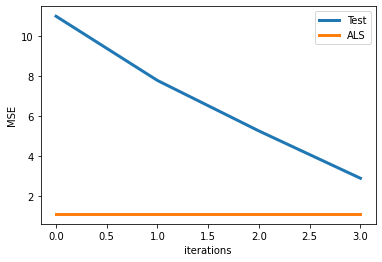

In [168]:
plot_learning_curve(als)